In [1]:
#Step 3 trains on the data from the hospital BIDMC and tests on the patients in MGB using logistic regression. 
#This data is coming from the training data only. 

In [ ]:
#Import all the necessary modules. 
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import csv

In [2]:
#Load in training data feature matrix. 
X = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')

#Select the relevant columns from the feature matrix to test performance of the training data. 
y_data = X[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']

#Merge X and y based on 'BDSPPatientID'.
Xy = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/train_data_.csv')


In [4]:
#The following code is used to train the data on BIDMC patients with their assigned features and test it on MGB. 
#This code also calculates the importances of the features. 
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-2]

#Separate data by hospital.
train_hospital = 'BIDMC'
test_hospital = 'MGB'

X_train = X[Xy['hospital'] == train_hospital]
y_train = y[Xy['hospital'] == train_hospital]

X_test = X[Xy['hospital'] == test_hospital]
y_test = y[Xy['hospital'] == test_hospital]

#Ensuring only features from the feature matrix are included in the training. 
X_train = X_train.loc[:, "CT":"ICD_852.2or3"] 
X_test = X_test.loc[:, "CT":"ICD_852.2or3"]

all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

#Creating a dictionary to store the feature importances.
feature_importances_dict = {feature: [] for feature in X.columns}

model = LogisticRegression(
    penalty='elasticnet',
    class_weight=None, random_state=2023,
    solver='saga', max_iter=10000
)

search_spaces = {
    'C': (1e-4, 1e+4, 'log-uniform'),
    'l1_ratio': (0.01, 0.99),
}
model_cv = BayesSearchCV(model,
                         search_spaces,
                         n_iter=50, scoring='roc_auc', n_jobs=15,
                         cv=5, random_state=2023)



model_cv.fit(X_train, y_train)

#Find the best hyperparameters and append them.
best_hparams = model_cv.best_params_
best_C = best_hparams['C']
best_l1_ratio = best_hparams['l1_ratio']
final_Cs.append(best_C)
final_l1.append(best_l1_ratio)

model = model_cv.best_estimator_

ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]

fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred)  
best_cutoff = cutoffs[np.argmax(tpr - fpr)]

fpr, tpr, _ = roc_curve(y_test, yte_pred)
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)

#Store the predictions and true labels. 
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(y_data[y_data['hospital'] == test_hospital]['BDSPPatientID'])

#Save the information for the plots you will create.
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)

#Extract feature importances (coefficients).
feature_importances = model.coef_[0]
for feature, importance in zip(X_train.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

print("Feature importances:")
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Feature importances:
            Feature  Importance
24          sdh_pos    4.207338
66      history_sdh    1.693048
27    tentorium_pos    1.329313
47      herniat_neg    1.305168
13     hematoma_pos    1.296088
..              ...         ...
31   recent sdh_pos   -0.745403
6     stabl sdh_pos   -1.247178
14  chronic sdh_pos   -1.282660
33    known sdh_pos   -1.359219
1               MRI   -1.390657

[71 rows x 2 columns]


In [6]:
#Print the AUC_ROC and AUC_PRC values. 
print(auc_cv)
print(auc_pr)

[0.9585176991150443]
[0.8271271522540314]


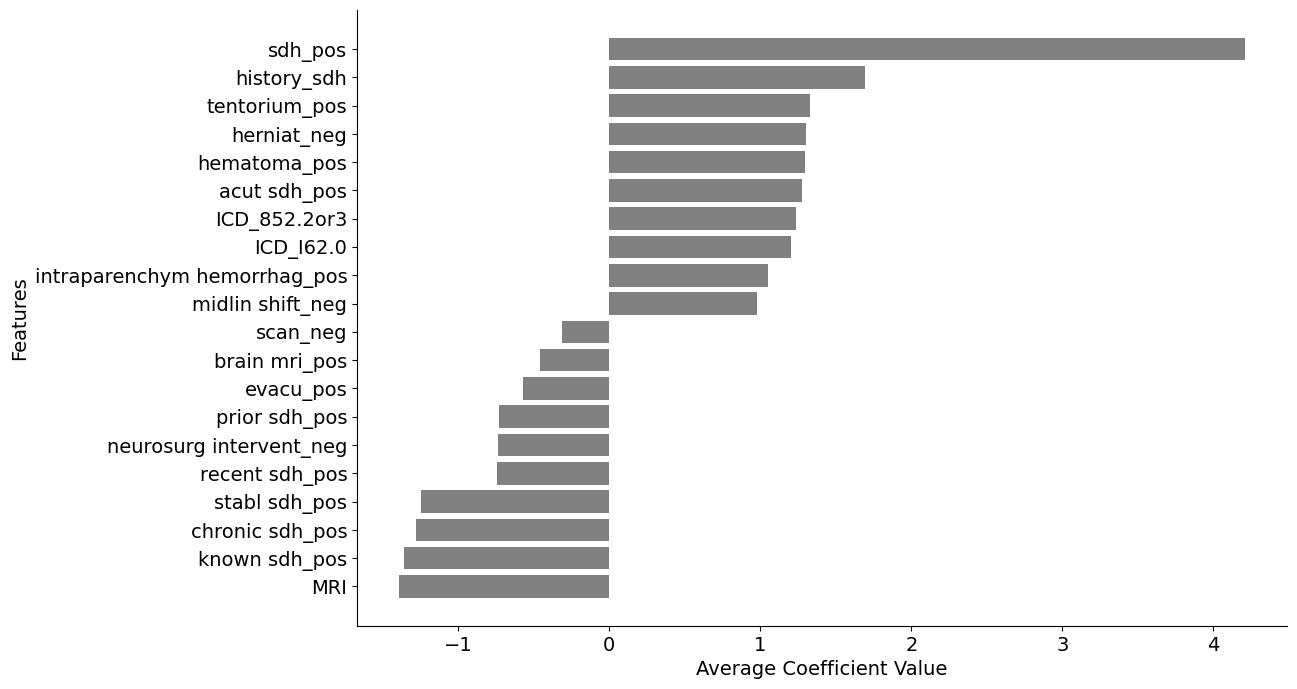

In [15]:
#Making the feature importances plot for training on BIDMC and testing on MGB. 

#Save the DataFrame to a CSV file.
feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/trainBIDMC_testMGB_feat_importances_.csv', index=False)

#Drop unwanted columns from feature_importances_dict.
drop = ['BDSPPatientID', 'Site', 'annot', 'ContactDate', 'NoteFileName', 'Unnamed: 0']
for item in drop:
    del feature_importances_dict[item]

#Aggregate feature importances by averaging over each of the folds.
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

#Select the top 10 and bottom 10 features.
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

#Combine top and bottom features for plotting.
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

#Plot feature importances. 
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey')

#Set the font size for axis labels and ticks. 
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
# Set the font size for tick labels. 
plt.tick_params(axis='both', which='major', labelsize=14)  

#Invert y-axis to have the most important feature on top. 
plt.gca().invert_yaxis()

#Remove the top and right spines. 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Save the plot.
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/trainBIDMC_testMGB_feat_importances_.png', bbox_inches='tight')

#Show the plot.
plt.show()



/tmp/ipykernel_1876/166333556.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize=14, frameon=False)


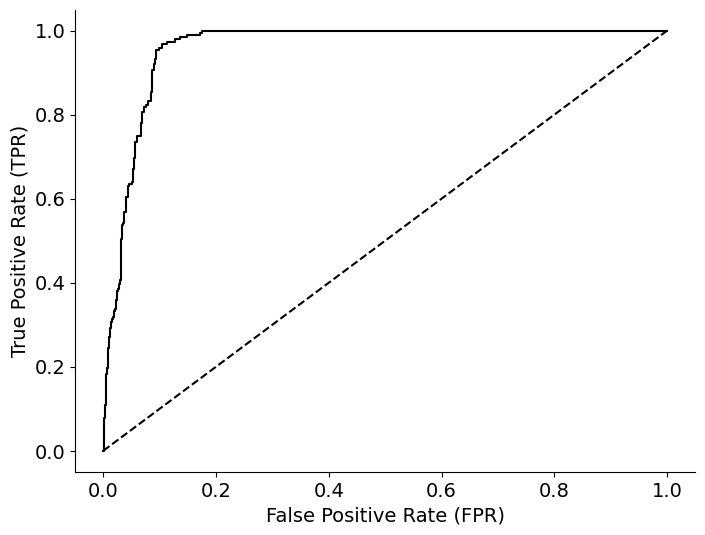

/tmp/ipykernel_1876/166333556.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=14, frameon=False)


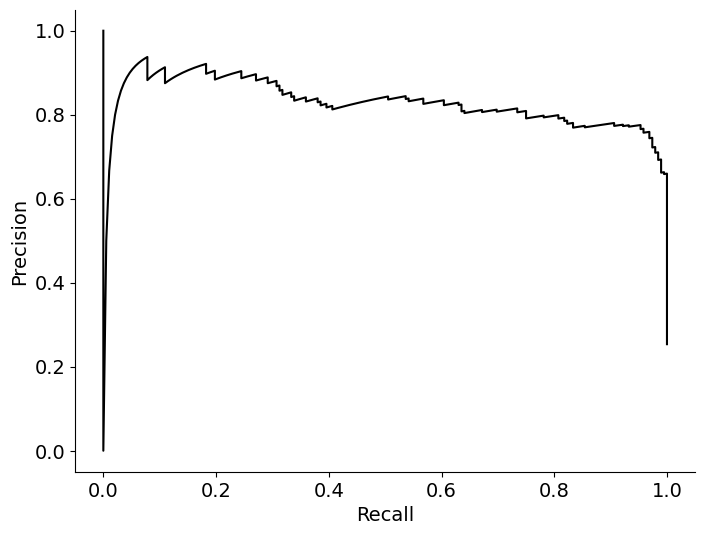

0.9585176991150443
[0.8271271522540314]
0.8345323741007195


In [16]:
#Plotting AUC_ROC and AUC_PR graphs. 

# Plot all ROC curves overlaid on a single graph. 
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=14, frameon=False)
#Set font size for tick labels
plt.tick_params(axis='both', which='major', labelsize=14)  

#Remove the top and right spines. 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/AUC_iter_MGB_.png', bbox_inches='tight')
plt.show()

#Plot all PR curves overlaid on a single graph. 
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, color='black')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='lower left', fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)  

#Remove the top and right spines. 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/PR_iter_MGB_.png', bbox_inches='tight')
plt.show()

#Create a DataFrame to hold the results. 
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

#Save the DataFrame to a CSV file. 
results_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/LR_iter_pred_MGB_.csv', index=False)

#Calculate the final AUC and F1 scores.
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

#Save all the data.
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame(predictions[0])
df_pred = pd.concat([df_pred]).reset_index()
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/LR_iter_MGB_.csv')

# Print the final data. 
print(auc_final)
print(auc_pr)
print(f1_final)